# SETUP

In [10]:
import sys
sys.path.insert(0,'..')
from spectral_cube import SpectralCube
from medzoo_imports import create_model, DiceLoss, Trainer, compute_per_channel_dice
from compare_methods import Evaluator
from os import listdir
from scipy import ndimage as ndi
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
import torch
from datetime import datetime
from astropy.io import fits
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel
from scipy import ndimage as ndi
from skimage.util.shape import view_as_windows
import skimage.measure as skmeas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap
import astropy.constants as const

from numpy.lib.stride_tricks import as_strided
import pickle
from sklearn.mixture import GaussianMixture
from scipy import stats
from datetime import datetime

## Load model

Properties of pre-trained model

In [2]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=2
inChannels=1
terminal_show_freq=50
model='VNET'
opt='adam'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}
k = 0
model_name = model
date_str = ""
save = '../saved_models_12052021_183655_/fold_' + str(k) + '_checkpoints/'

Load pre-trained model

In [368]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.pretrained = pretrained
model_loc = "../results/VNET__last_epoch.pth"
# args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
model, optimizer = create_model(args)
model.restore_checkpoint(args.pretrained)
model.eval()
print("Loaded")

Building Model . . . . . . . .VNET
VNET Number of params: 45603934
Loaded


In [90]:
train_df = pd.read_csv("../saved_models_21052021_163310_loud_1/fold_%s_checkpoints/VNET_/train.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models_21052021_163310_loud_1/fold_%s_checkpoints/VNET_/val.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
train_df["epoch"] = train_df["epoch"].str.split("Loss", expand=True)[0]
val_df["epoch"] = val_df["epoch"].str.split("Loss", expand=True)[0]
train_df["loss"] = train_df["loss"].str.split(" ", expand=True)[0]
val_df["loss"] = val_df["loss"].str.split(" ", expand=True)[0]

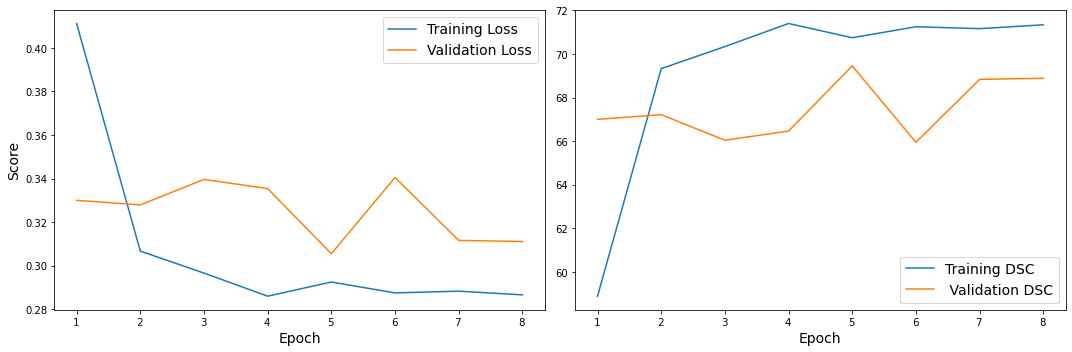

In [91]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[0].set_xlabel("Epoch", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Score", fontsize=14)
# axes[1].set_ylabel("Score")
axes[0].legend(fontsize=14)
axes[1].legend(fontsize=14)
fig.tight_layout()

# Evaluate Model

Load the test subcubes

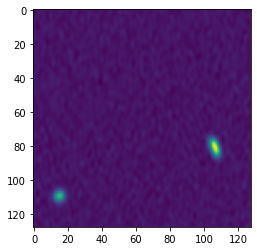

In [369]:
orig_data = fits.getdata("../data/training/loudInput/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
orig_subcube = orig_data[133:197, 800:800+128, 1500:1500+128]
real_subcube = realseg_data[133:197, 800:800+128, 1500:1500+128]
data_loader_tensor = torch.FloatTensor(np.moveaxis(orig_subcube, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
plt.imshow(orig_subcube[32])

Infer

In [380]:
model.eval()
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
out_np = np.moveaxis(out_cube.squeeze()[1].numpy(), 2, 0)
clipped = (out_np > 0).astype(int)

Evaluate

In [383]:
mask_labels = skmeas.label(real_subcube)
mos_name = '1245mosC'
eve = Evaluator(orig_subcube, mask_labels, mos_name)
vnet_labels = skmeas.label(clipped)
evaluated = eve.get_p_score(vnet_labels)

OUTSTAT True positive: 3
OUTSTAT False negative: 0
OUTSTAT False positive: 0
OUTSTAT Recall: 1.0
OUTSTAT Precision: 1.0
OUTSTAT F score: 1.0
OUTSTAT Undermerging score: 0.003350348629474541
OUTSTAT Overmerging score: 0.0020294964993607034
OUTSTAT Total area score: 0.003917102498012949
OUTSTAT Background skew score: 181.37961810036407
OUTSTAT Background kurtosis score: 485.2702938762278
OUTSTAT Background mean score: -1.8978089e-06
OUTSTAT Combined A: 1.0000076718165616
OUTSTAT Combined B: 0.9982057674522645


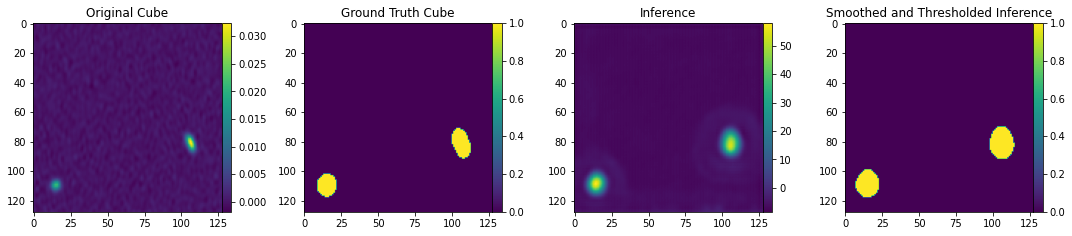

In [381]:
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
im0 = axes[0].imshow(orig_subcube[32])
cax0 = make_axes_locatable(axes[0]).append_axes("right", size="5%",pad=0)
fig.colorbar(im0, cax=cax0)
axes[0].set_title("Original Cube")


im3 = axes[1].imshow(real_subcube[32])
cax3 = make_axes_locatable(axes[1]).append_axes("right", size="5%",pad=0)
fig.colorbar(im3, cax=cax3)
axes[1].set_title("Ground Truth Cube")

im1 = axes[2].imshow(out_np[32])
cax1 = make_axes_locatable(axes[2]).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
axes[2].set_title("Inference")

im2 = axes[3].imshow(clipped[32])
cax2 = make_axes_locatable(axes[3]).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
axes[3].set_title("Smoothed and Thresholded Inference")


fig.tight_layout()

## Plot Combined Scores

In [284]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],
"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}
df = pd.DataFrame(freq_dict.values(), columns=[["freq_1", "freq_2"]])
df["file_names"] = freq_dict.keys()
df["freq_1_round"] = np.round(df['freq_1']*1e-6).astype(int).astype(str)
df["freq_2_round"] = np.round(df['freq_2']*1e-6).astype(int).astype(str)
df['freq_labels'] = df[['freq_1_round', 'freq_2_round']].agg('-'.join, axis=1)
df.columns = df.columns.map(''.join)

In [405]:
with open("../results/mto_performance_loudInput.txt", "rb") as fp:
    mto_time = pickle.load(fp)
mto_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in mto_time.items()], columns=['freq_1', 'time_taken'])
mto_df = pd.read_csv("../results/loud_MTO_eval.txt", index_col=0)
full_mto_df = pd.merge(df[df.file_names.str.contains("1245")][['freq_1', 'freq_labels']], pd.merge(mto_df, mto_time_df))
full_mto_df['recall'] = full_mto_df.tp / (full_mto_df.tp + full_mto_df.fn)
full_mto_df['precision'] = full_mto_df.tp / (full_mto_df.tp + full_mto_df.fp)


In [410]:
vnet_df = pd.read_csv("../results/loud_VNET_eval.txt", header=None, names=["tp", "fp", "fn", "f_score", "um", "om", "area_score", "s", "k", "bg_mean", "combined_one", "combined_two", "file_name"])
with open("../results/vnet_performance_saved_models_28052021_101114_loud_14.txt", "rb") as fp:
    vnet_time = pickle.load(fp)
vnet_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in vnet_time.items()], columns=['freq_1', 'time_taken'])
vnet_df["freq_1"] = [freq_dict["mask_" + i + '.fits'][0]  for i in vnet_df.file_name]
vnet_df.columns = vnet_df.columns.map(''.join)
full_vnet_df = pd.merge(df[df.file_names.str.contains("1245")][['freq_1', 'freq_labels']], pd.merge(vnet_df, vnet_time_df))
full_vnet_df['recall'] = full_vnet_df.tp / (full_vnet_df.tp + full_vnet_df.fn)
full_vnet_df['precision'] = full_vnet_df.tp / (full_vnet_df.tp + full_vnet_df.fp)

In [408]:
with open("../results/loud_SOFIA_eval.txt", "rb") as fp:
    sofia_eval = pickle.load(fp)
with open("../results/sofia_performance_loudInput.txt", "rb") as fp:
    sofia_time = pickle.load(fp)
sofia_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in sofia_time.items()], columns=['freq_1', 'time_taken'])
sofia_dict = {}
for i in [0, 2, 4, 6, 8, 10, 12]:
    sofia_dict.update({sofia_eval[i]: sofia_eval[i+1]})
sofia_df = pd.DataFrame.from_dict(sofia_dict, orient='index', columns=[["tp", "fp", "fn", "f_score", "um", "om", "area_score", "s", "k", "bg_mean", "combined_one", "combined_two"]])
sofia_df.columns = sofia_df.columns.map(''.join)
sofia_df["freq_1"] = [freq_dict["mask_" + i + '.fits'][0]  for i in sofia_df.index]
full_sofia_df = pd.merge(pd.merge(df[['freq_1', 'freq_labels']], sofia_df), pd.merge(df[['freq_1', 'freq_labels']], sofia_time_df), on='freq_labels')

full_sofia_df['recall'] = full_sofia_df.tp / (full_sofia_df.tp + full_sofia_df.fn)
full_sofia_df['precision'] = full_sofia_df.tp / (full_sofia_df.tp + full_sofia_df.fp)

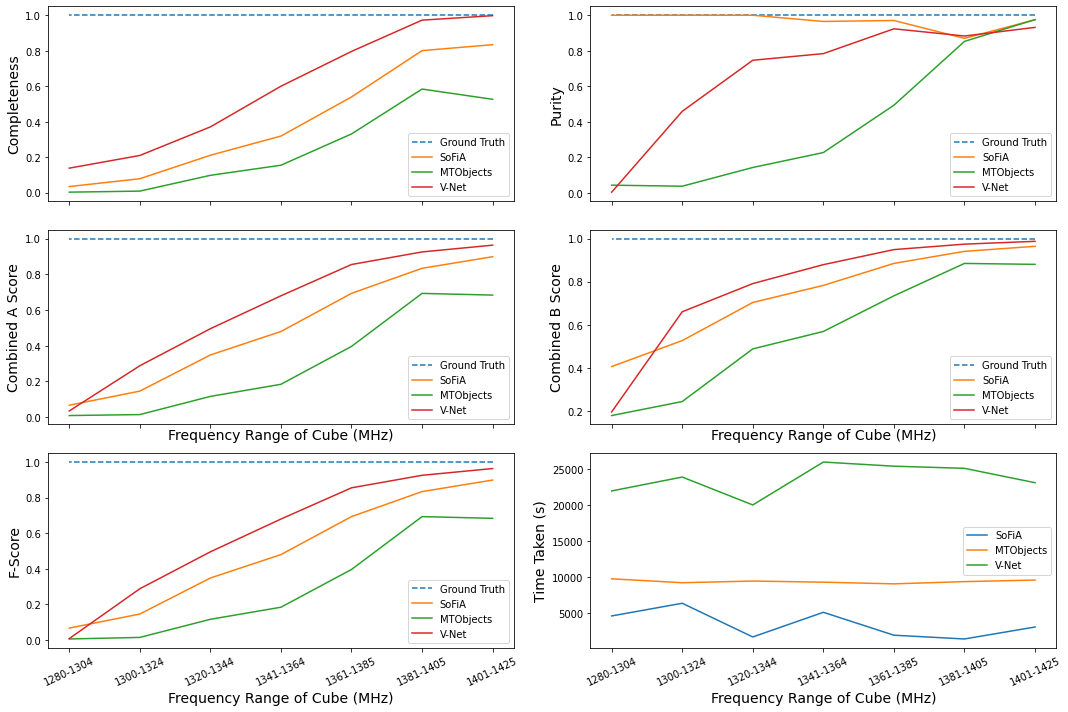

In [411]:
fig, (ax1, ax3, ax4) = plt.subplots(3, 2, figsize=(15,10), sharex=True)
ax1[0].set_ylabel("Completeness", fontsize=14)
# ax1[0].set_xticks(ticks=full_sofia_df.freq_1)
# ax1[0].set_xticklabels(full_sofia_df.freq_labels, rotation=25)
ax1[0].plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax1[0].plot(full_mto_df.freq_1, full_sofia_df.recall, label="SoFiA")
ax1[0].plot(full_mto_df.freq_1, full_mto_df.recall, label="MTObjects")
ax1[0].plot(full_vnet_df.freq_1, full_vnet_df.recall, label="V-Net")
ax1[0].tick_params(axis='y')
# ax1[0].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1[0].legend()


ax1[1].set_ylabel("Purity", fontsize=14)
# ax1[1].set_xticks(ticks=full_sofia_df.freq_1)
# ax1[1].set_xticklabels(full_sofia_df.freq_labels, rotation=25)
ax1[1].plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax1[1].plot(full_mto_df.freq_1, full_sofia_df.precision, label="SoFiA")
ax1[1].plot(full_mto_df.freq_1, full_mto_df.precision, label="MTObjects")
ax1[1].plot(full_vnet_df.freq_1, full_vnet_df.precision, label="V-Net")
ax1[1].tick_params(axis='y')
ax1[1].legend()
# ax1[1].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)

# fig.tight_layout()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax3[0].set_ylabel("Combined A Score", fontsize=14)
ax3[0].set_xticks(ticks=full_mto_df.freq_1)
ax3[0].set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax3[0].plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax3[0].plot(full_mto_df.freq_1, full_sofia_df.combined_one, label="SoFiA")
ax3[0].plot(full_mto_df.freq_1, full_mto_df.combined_one, label="MTObjects")
ax3[0].plot(full_vnet_df.freq_1, full_vnet_df.combined_one, label="V-Net")
ax3[0].tick_params(axis='y')
ax3[0].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3[0].legend()


ax3[1].set_ylabel("Combined B Score", fontsize=14)
ax3[1].set_xticks(ticks=full_mto_df.freq_1)
ax3[1].set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax3[1].plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax3[1].plot(full_mto_df.freq_1, full_sofia_df.combined_two, label="SoFiA")
ax3[1].plot(full_mto_df.freq_1, full_mto_df.combined_two, label="MTObjects")
ax3[1].plot(full_vnet_df.freq_1, full_vnet_df.combined_two, label="V-Net")
ax3[1].tick_params(axis='y')
ax3[1].legend()
ax3[1].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)


ax4[0].set_ylabel("F-Score", fontsize=14)
ax4[0].set_xticks(ticks=full_mto_df.freq_1)
ax4[0].set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax4[0].plot(full_mto_df.freq_1, [1]*7, label="Ground Truth", linestyle="--")
ax4[0].plot(full_mto_df.freq_1, full_sofia_df.f_score, label="SoFiA")
ax4[0].plot(full_mto_df.freq_1, full_mto_df.f_score, label="MTObjects")
ax4[0].plot(full_vnet_df.freq_1, full_vnet_df.f_score, label="V-Net")
ax4[0].tick_params(axis='y')
ax4[0].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax4[0].legend()


ax4[1].set_ylabel("Time Taken (s)", fontsize=14)
ax4[1].set_xticks(ticks=full_mto_df.freq_1)
ax4[1].set_xticklabels(full_mto_df.freq_labels, rotation=25)
ax4[1].plot(full_mto_df.freq_1, full_sofia_df.time_taken, label="SoFiA")
ax4[1].plot(full_mto_df.freq_1, full_mto_df.time_taken, label="MTObjects")
ax4[1].plot(full_vnet_df.freq_1, full_vnet_df.time_taken, label="V-Net")
ax4[1].tick_params(axis='y')
ax4[1].legend()
ax4[1].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)


fig.tight_layout()

## Create catalog of sources and their attributes

In [384]:
# mto_cat_df = pd.read_pickle("../results/loud_MTO_catalog.txt")
# vnet_cat_df = pd.read_pickle("../results/loud_VNET_catalog.txt")
sofia_cat_df = pd.read_csv("../results/loud_SOFIA_catalog.txt")

In [388]:
sofia_cat_df['Class'] = sofia_cat_df.true_positive_mocks | sofia_cat_df.true_positive_real

In [393]:
print("True Positives = ", len(sofia_cat_df[sofia_cat_df.Class]))
print("False Positives = ", len(sofia_cat_df[~sofia_cat_df.Class]))

True Positives =  1753
False Positives =  84


In [206]:
cols_to_keep = ['max_loc', 'seg_mask', 'area', 'peak_flux', 'eccentricity', 'flatness', 'brightest_pix',
         'n_channels', 'nx', 'ny', 'tot_flux', 'true_positive_mocks', 'true_positive_real',
        'bbox-0', 'bbox-3', 'bbox-1', 'bbox-4', 'bbox-2', 'bbox-5']
result = pd.merge(vnet_cat_df[cols_to_keep], mto_cat_df[cols_to_keep], on="max_loc", suffixes=("_vnet", "_mto"))

In [169]:
comb_df = pd.DataFrame(columns=cols_to_keep)
for  i, row in result.iterrows():
    if row.area_vnet >= row.area_mto:
        suffix = "_vnet"
    else:
        suffix = "_mto"
    comb_df.append(row[k+suffix if k != "max_loc" else k for k in cols_to_keep])

### Insert into GT masks
Insert false positives that were cross-referenced and found to be real sources

In [282]:
for  i, row in comb_df[(~comb_df.true_positive_mocks) & comb_df.true_positive_real].iterrows():
    mask_data[
        int(row['bbox-0']):int(row['bbox-3']),
        int(row['bbox-1']):int(row['bbox-4']),
        int(row['bbox-2']):int(row['bbox-5'])] = row.seG_mask

In [283]:
fits.write_to("../data/training/catTarget", mask_data)

AttributeError: module 'astropy.io.fits' has no attribute 'write_to'

## Train ML to identify tps

In [123]:
x_train, x_test, y_train, y_test = train_test_split(
    comb_df[['area', 'peak_flux', 'eccentricity', 'flatness', 'brightest_pix',
             'n_channels', 'nx', 'ny', 'tot_flux']],
    comb_df.Class.astype(int), test_size=0.33, random_state=42)

In [149]:
logit_model = LogisticRegression(class_weight='balanced', max_iter=1000)
tree_model = tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced') 
svm_model = SVC(probability=True, class_weight='balanced')
knn_model = KNeighborsClassifier(n_neighbors=3)
bayes_model = GaussianNB()
models = [logit_model, tree_model, rf, svm_model, knn_model, bayes_model]

accuracy = []
precision = []
recall = []
f1 = []
for model in models:
    model.fit(x_train, y_train)
    predicted = pd.DataFrame(model.predict(x_test))
    accuracy += [metrics.accuracy_score(y_test, predicted)]
    precision += [metrics.precision_score(y_test, predicted, pos_label=1)]
    recall += [metrics.recall_score(y_test, predicted, pos_label=1)]
    f1 += [metrics.f1_score(y_test, predicted, pos_label=1)]

results = pd.DataFrame([accuracy, precision, recall, f1]).T
results.columns = ["accuracy", "precision", "recall", "f1"]
results.index = ["LR", "DT", "RF", "SVM", "KNN", "Bayes"]
results.sort_values("f1", ascending=False)

,accuracy,precision,recall,f1
RF,0.639106,0.673943,0.647020,0.660207
KNN,0.577005,0.607856,0.618206,0.612987
DT,0.606813,0.722163,0.445972,0.551417
LR,0.600071,0.707039,0.447282,0.547934
SVM,0.551810,0.740000,0.266536,0.391911
Bayes,0.501065,0.674352,0.153242,0.249733
